### EDA analysis for cell viability

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from src.auxiliar_functions import AuxFunctions
import numpy as np

In [3]:
# Global style (paper-friendly)
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.linewidth": 1.0,
})

- Reading raw data

In [4]:
df_cell_viability = pd.read_excel("../raw_data/Cell Viability.xlsx")
df_cell_viability.head()

,Cell line,Enzyme,Treatment (%),Cell viability (% of control)
0,RQ,ASNase,0,100.000000
1,RQ,ASNase,0,100.000000
2,RQ,ASNase,0,100.000000
3,RQ,ASNase,50,102.024291
4,RQ,ASNase,50,129.554656


- Making preparation for ploting

In [5]:
df_to_process = df_cell_viability.copy()
df_to_process["Enzyme"] = df_to_process["Enzyme"].astype(str).str.strip()
df_to_process["Treatment (%)"] = pd.to_numeric(df_to_process["Treatment (%)"], errors="coerce")
df_to_process["Cell viability (% of control)"] = pd.to_numeric(df_to_process["Cell viability (% of control)"], errors="coerce")
df_to_process = df_to_process.dropna(subset=["Cell line", "Enzyme", "Treatment (%)", "Cell viability (% of control)"])
df_to_process

,Cell line,Enzyme,Treatment (%),Cell viability (% of control)
0,RQ,ASNase,0,100.000000
1,RQ,ASNase,0,100.000000
2,RQ,ASNase,0,100.000000
3,RQ,ASNase,50,102.024291
4,RQ,ASNase,50,129.554656
...,...,...,...,...
175,MCF-7,ADI,70,80.126582
176,MCF-7,ADI,70,78.227848
177,MCF-7,ADI,90,48.536210
178,MCF-7,ADI,90,40.446841


In [6]:
# Canonical order for treatments
treat_order = [0, 50, 70, 90]
present_treats = [t for t in treat_order if t in set(df_to_process["Treatment (%)"].unique())]
if len(present_treats) < 2:
    raise ValueError("Not enough distinct treatment levels found.")

In [7]:
df_to_process["Treatment (%)"] = pd.Categorical(df_to_process["Treatment (%)"], categories=present_treats, ordered=True)


In [8]:
enzyme_order = [
    "ASNase",
    "ADI",
    "GLNase",
    "GO",
    "SDH"]

present_enzymes = list(df_to_process["Enzyme"].unique())
enzyme_order = [e for e in enzyme_order if e in present_enzymes] + [e for e in present_enzymes if e not in enzyme_order]

In [9]:
summary = (
    df_to_process.groupby(["Enzyme", "Treatment (%)"], as_index=False)
           .agg(
               mean_viability=("Cell viability (% of control)", "mean"),
               sd_viability=("Cell viability (% of control)", "std"),
               n=("Cell viability (% of control)", "size"),
           )
           .sort_values(["Enzyme", "Treatment (%)"])
)

summary.head()

,Enzyme,Treatment (%),mean_viability,sd_viability,n
0,ADI,0,100.000000,0.000000,9
1,ADI,50,108.559109,13.584444,9
2,ADI,70,92.399176,14.723614,9
3,ADI,90,36.688059,5.581021,9
4,ASNase,0,100.000000,0.000000,9


In [10]:
letters_df = AuxFunctions.compute_letters_per_enzyme(
    df_to_process, 
    alpha=0.05, 
    adjust="holm", 
    present_treats=present_treats,
    treatment_column="Treatment (%)", 
    viability_column="Cell viability (% of control)")
letters_df.head() if not letters_df.empty else "No letters produced."

,Enzyme,Treatment (%),Letters
1,ADI,0,a
0,ADI,50,a
2,ADI,70,a
3,ADI,90,b
6,ASNase,0,b


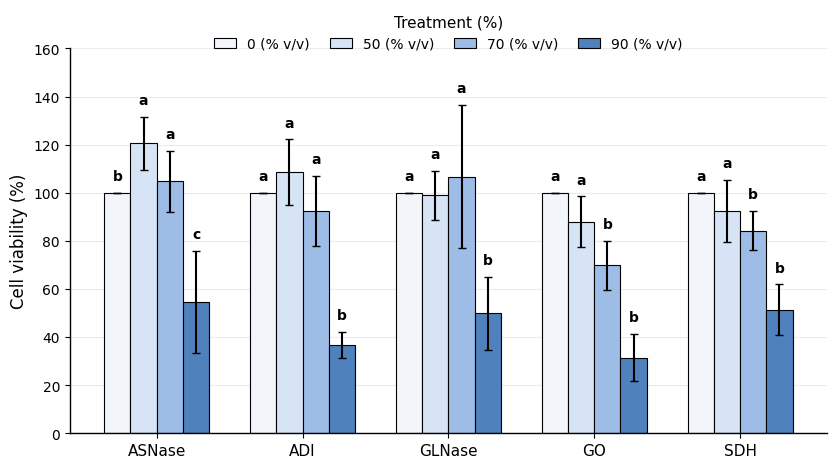

In [13]:
# ============================================================
# Bar plots with Dunn letters, short enzyme labels
# ============================================================

# Pastel blue palette (treatment levels)
pastel_blue = {
    0: "#F2F6FB",  # very light blue
    50: "#D6E4F5",  # light blue
    70: "#9DBCE6",  # medium blue
    90: "#4F81BD",  # deeper blue
}

x_labels = enzyme_order

treatments = list(df_to_process["Treatment (%)"].cat.categories)
n_groups = len(treatments)

# Reindex summary to desired order
sum_plot = summary.set_index(["Enzyme", "Treatment (%)"]).reindex(
    pd.MultiIndex.from_product([enzyme_order, treatments], names=["Enzyme", "Treatment (%)"])
).reset_index()

x = np.arange(len(enzyme_order))
bar_width = 0.18 if n_groups >= 4 else 0.22

fig_w = max(8.5, 1.35 * len(enzyme_order))
fig_h = 4.8
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# --- Bars + error bars ONLY (no replicate dots)
for i, t in enumerate(treatments):
    t_float = float(t)

    sub = sum_plot[sum_plot["Treatment (%)"] == t].set_index("Enzyme").reindex(enzyme_order)
    means = sub["mean_viability"].values
    sds = sub["sd_viability"].values

    offsets = (i - (n_groups - 1) / 2) * bar_width
    xpos = x + offsets

    ax.bar(
        xpos,
        means,
        width=bar_width,
        yerr=sds,
        capsize=3,
        edgecolor="black",
        linewidth=0.8,
        color=pastel_blue.get(t_float, "#CCCCCC"),
        label=f"{t_float:g} (% v/v)",
        zorder=2
    )

# --- Dunn letters above bars
if not letters_df.empty:
    letter_map = {(r["Enzyme"], float(r["Treatment (%)"])): r["Letters"] for _, r in letters_df.iterrows()}

    for i, t in enumerate(treatments):
        t_float = float(t)
        offsets = (i - (n_groups - 1) / 2) * bar_width
        xpos = x + offsets

        sub = sum_plot[sum_plot["Treatment (%)"] == t].set_index("Enzyme").reindex(enzyme_order)
        means = sub["mean_viability"].values
        sds = sub["sd_viability"].values

        for j, enz in enumerate(enzyme_order):
            L = letter_map.get((enz, t_float), "")
            if L == "" or np.isnan(means[j]):
                continue

            y = means[j] + (0 if np.isnan(sds[j]) else sds[j]) + 4

            ax.text(
                xpos[j],
                y,
                L,
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
                zorder=3
            )

# --- Axes formatting (no title, no x-label)
ax.set_ylabel("Cell viability (%)")
ax.set_xlabel("")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=11)

# Y-limits with headroom
y_max = np.nanmax(sum_plot["mean_viability"] + sum_plot["sd_viability"])
ax.set_ylim(0, max(120, np.ceil((y_max + 15) / 10) * 10))

# Paper style
ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend: centered and clean
ax.legend(
    title="Treatment (%)",
    frameon=False,
    ncol=min(4, n_groups),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    handlelength=1.6,
    columnspacing=1.4
)

plt.tight_layout()
plt.show()
